# Tłumaczenie działania sieci konwolucyjnej diagnozującej zapalenie płuc za pomocą metody LIME
Na podstawie: [Pneumonia Detection using CNN(92.6% Accuracy)](https://www.kaggle.com/code/madz2000/pneumonia-detection-using-cnn-92-6-accuracy#Data-Visualization-&-Preprocessing)

Z wykorzystaniem datasetu: [Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia)

# Import bibliotek

In [1]:
import numpy as np
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
import cv2
import os
from skimage.segmentation import mark_boundaries

Using TensorFlow backend.


# Czytanie danych

In [2]:
labels = ['PNEUMONIA', 'NORMAL']
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (150, 150))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [3]:
train = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/train')
test = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/test')

OpenCV(4.2.0) /io/opencv/modules/imgproc/src/resize.cpp:4045: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.2.0) /io/opencv/modules/imgproc/src/resize.cpp:4045: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



In [4]:
x_train = []
y_train = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

x_train = np.array(x_train) / 255

x_test = []
y_test = []

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    

x_test = np.array(x_test) / 255

In [5]:
x_train = x_train.reshape(-1, 150, 150, 1)
y_train = np.array(y_train)

x_test = x_test.reshape(-1, 150, 150, 1)
y_test = np.array(y_test)

def to_rgb(x):
    x_rgb = np.zeros((x.shape[0], 150, 150, 3))
    for i in range(3):
        x_rgb[..., i] = x[..., 0]
    return x_rgb

x_train = to_rgb(x_train)
x_test = to_rgb(x_test)

# Tworzenie modelu

In [6]:
model = keras.Sequential(
    [
     keras.Input(shape=(150,150,3)),
     layers.Conv2D(16, 3, activation='relu'),
     layers.MaxPooling2D(),
     layers.Flatten(),
     layers.Dense(10)
    ]
)

In [7]:
model.compile(
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  optimizer=keras.optimizers.Adam(),
  metrics=['accuracy']
)

# Trenowanie

In [8]:
model.fit(
        x_train, 
        y_train, 
        epochs=12, 
        batch_size=32, 
        validation_data = (x_test, y_test))

Train on 5216 samples, validate on 624 samples
Epoch 1/12
5216/5216 [==============================] - 35s 7ms/sample - loss: 0.2432 - accuracy: 0.8990 - val_loss: 0.9587 - val_accuracy: 0.6859
Epoch 2/12
5216/5216 [==============================] - 34s 7ms/sample - loss: 0.0783 - accuracy: 0.9705 - val_loss: 1.1124 - val_accuracy: 0.7260
Epoch 3/12
5216/5216 [==============================] - 35s 7ms/sample - loss: 0.0532 - accuracy: 0.9831 - val_loss: 1.1723 - val_accuracy: 0.7163
Epoch 4/12
5216/5216 [==============================] - 35s 7ms/sample - loss: 0.0376 - accuracy: 0.9891 - val_loss: 1.1587 - val_accuracy: 0.7484
Epoch 5/12
5216/5216 [==============================] - 35s 7ms/sample - loss: 0.0290 - accuracy: 0.9914 - val_loss: 0.7115 - val_accuracy: 0.7869
Epoch 6/12
5216/5216 [==============================] - 35s 7ms/sample - loss: 0.0251 - accuracy: 0.9935 - val_loss: 1.1063 - val_accuracy: 0.7500
Epoch 7/12
5216/5216 [==============================] - 35s 7ms/sample 

# Metoda LIME i wizualizacja

In [9]:
explainer = lime.lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
         x_test[10], 
         model.predict
)

100% |########################################################################|


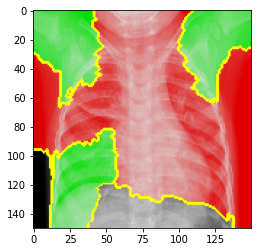

In [10]:
original, overlay = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig = plt.imshow(mark_boundaries(original, overlay))
plt.show()